# **CS985/6 Spotify Classification / Regression Problem 2021**

# **Overview**

The overall task has been divided into two tasks; One classification and one regression problem. In the classification problem we aim to build a machine learnin  model that will predict the genre of a song. Genre is a categorical variable and as such this has been treated as a classification problem. The second taks is to build a machine learning model that predicts the popularity of the song. The popularity attribute is an interger value, so this is treated as a regression problem.

**The analysis is composed in 3 parts**



1.   Data Manipulation and Primary Analysis
2.   Supervised Model - Regression Analysis
3.   Supervised Model - Classification Analysis


In the Primary Analysis we focus on idenitfying relationships between the target cateogory and the different attributes. While there is strong indication of relations between other attirbutes we do not formally explore those for terms of simplicity and word count.

We then introduce the Regression and Classification Models built for these problems. We provide insight as to the reason we have chosen each model as well as an overall reflection as to why some models have worked better than others.























With regards to the main library used. We focused on Scikit-learn. Primarily on the supervised learning models and more specifically the regression and classification ones. Additionally we have made use of cross validation and other metrics like f1 score, neg mean square error and some smaller functions like plotting the confusion matrix.

We have also relied heavily on Pandas as a data processing library and Numpy. We have made use of Seaborn too for its correlation matrix plotting function.

# **Primary Analysis**

In [ ]:
# Imports
import io
import math
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.svm import SVC, SVR
from matplotlib.figure import Figure
from sklearn.linear_model import LinearRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing, metrics, cluster
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.metrics import precision_score, recall_score, f1_score,  accuracy_score, accuracy_score, mean_squared_error, plot_confusion_matrix
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier, VotingClassifier, GradientBoostingRegressor, RandomForestRegressor

In [ ]:
regression_training = pd.read_csv('CS98XRegressionTrain.csv')
regression_test = pd.read_csv('CS98XRegressionTest.csv')

In [ ]:
regression_training.head(5)

,Id,title,artist,top genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
0,1,My Happiness,Connie Francis,adult standards,1996,107,31,45,-8,13,28,150,75,3,44
1,2,Unchained Melody,The Teddy Bears,NaN,2011,114,44,53,-8,13,47,139,49,3,37
2,3,How Deep Is Your Love,Bee Gees,adult standards,1979,105,36,63,-9,13,67,245,11,3,77
3,4,Woman in Love,Barbra Streisand,adult standards,1980,170,28,47,-16,13,33,232,25,3,67
4,5,Goodbye Yellow Brick Road - Remastered 2014,Elton John,glam rock,1973,121,47,56,-8,15,40,193,45,3,63


In [ ]:
# Drop the Id column
x_test_Id = regression_test['Id']
#----------------------------------
regression_training.drop('Id', axis=1, inplace=True)
regression_test.drop('Id', axis=1, inplace=True)

In [ ]:
# Check the dimensions of the dataframe
regression_training.shape

(453, 14)

In [ ]:
regression_training.isna().sum()

title         0
artist        0
top genre    15
year          0
bpm           0
nrgy          0
dnce          0
dB            0
live          0
val           0
dur           0
acous         0
spch          0
pop           0
dtype: int64

In [ ]:
# Counting how many unique values we have per attribute and teh target column. 
# There are 86 different classes for top_genre, which which will be be challenging to predict for the limited number of instances per class.
unique_values = regression_training.nunique()
unique_values

title        451
artist       345
top genre     86
year          64
bpm          107
nrgy          90
dnce          77
dB            21
live          58
val           94
dur          202
acous         95
spch          29
pop           59
dtype: int64

From the fist exploratory analysis  the data appears of good general quality. There is only a small number of NA values, which we have removed. There is a slight concern with regards to the small number of data (453 rows), which is likely to affect the model performance. We have counted the number of instances per class and some classes are represented by very few number of instances.  We have also counted the number of unique values per feature. We observe that some features have limited number of unique values and the different attributes have ranking properties i.e for (val), (live), (nrgy) etc the higher the value the more positive the mood (val), the more likely to be a live recording (live), the more energetic the song (nrgy). This indicates that the data is of ordinal nature and as such can be treated as categorical variables.

We have also looked in detail the counts for the "pop" attribute and we observe that some ranks come with very small counts. This is likely to affect the model performance while training.

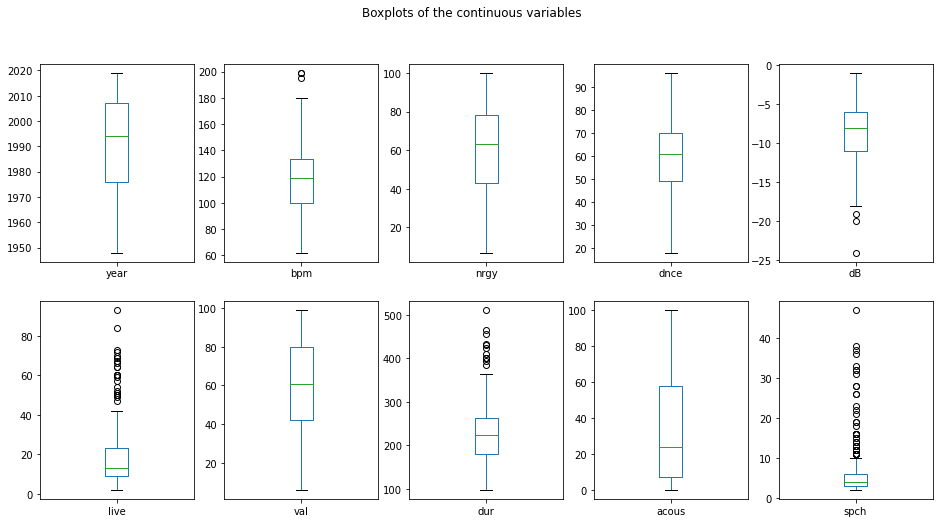

In [ ]:
#Create and display box plots of the continuous variables in the dataset
spotify_continuous = unique_values = regression_training[["year", "bpm", "nrgy","dnce","dB","live","val","dur", "acous", "spch"]]
spotify_continuous.plot(kind='box',subplots=True,layout=(2,5),figsize=(16,8),title="Boxplots of the continuous variables")
plt.show()

From the boxplots we see that the data comes in very different scales. We also observe most attributes have a large number of outliers . We have performed the downstream model with and without outliers (data not shown), but model performance was similar if not worse possible because of  teh small dataset. So we have opted to do the analysis including the outliers.

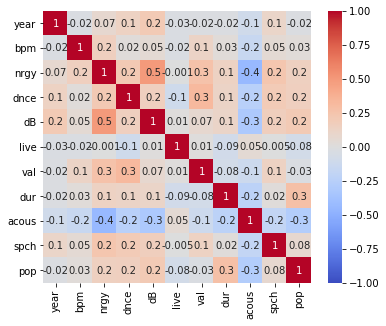

In [ ]:
plt.figure(figsize = (6,5))
sns.heatmap(regression_training.corr(method = "kendall"), annot = True, fmt = ".1g", vmin = -1, vmax =1, center =0,cmap="coolwarm")
plt.show()

We have performed Kendall correlation test (the default Pearson correlation assumes normal distribution), to identify the relationship between ordered ordinal data. From the result we see positive correlation between "pop" and "dur" or "pop" and "nrgy", "dnce" and "db", as well as negative correlation between "pop and "acous". This insidcates that there may be some potentially good classiifers among the data.

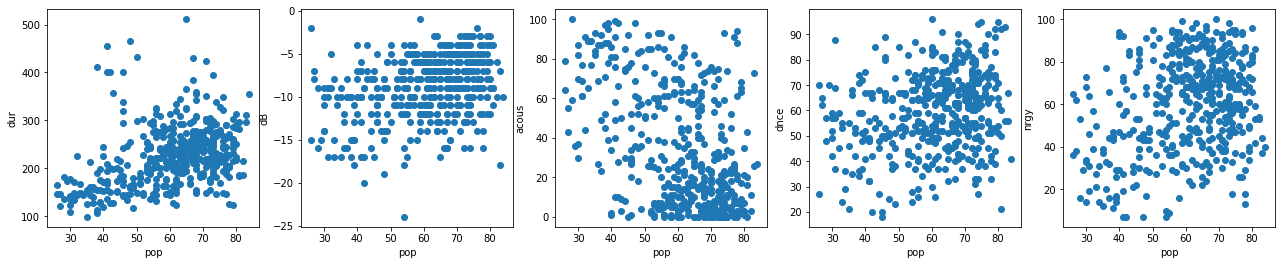

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(22,4))
axes[0].scatter(regression_training['pop'].values, regression_training['dur'].values)
axes[0].set_xlabel('pop')
axes[0].set_ylabel('dur')
axes[1].scatter(regression_training['pop'].values, regression_training['dB'].values)
axes[1].set_xlabel('pop')
axes[1].set_ylabel('dB')
axes[2].scatter(regression_training['pop'].values, regression_training['acous'].values)
axes[2].set_xlabel('pop')
axes[2].set_ylabel('acous')
axes[3].scatter(regression_training['pop'].values, regression_training['dnce'].values)
axes[3].set_xlabel('pop')
axes[3].set_ylabel('dnce')
axes[4].scatter(regression_training['pop'].values, regression_training['nrgy'].values)
axes[4].set_xlabel('pop')
axes[4].set_ylabel('nrgy')
plt.show()

We have plotted scatterplots for the best attributes that have shown correlation with the target cateogry "pop" on the correlation matrix. From the visual represenation we can comfrim the positive and negative correlations as shown above. We can also see visually the effect of the outliers in the spread of the data. However, we opted not to remove the rest of the reatures since there is always the posibility that there are some hidden relationships within the data that could help the machine learning algorithm.

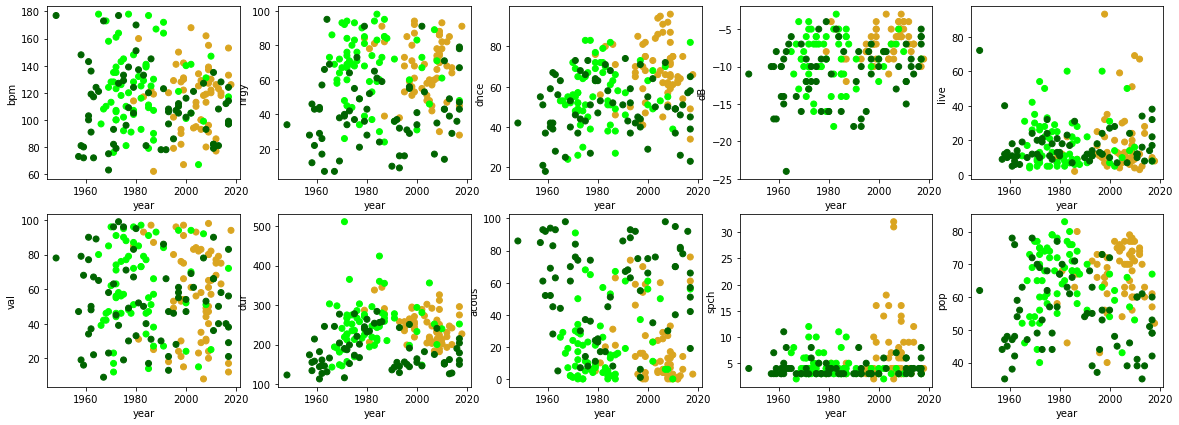

In [ ]:
# Preprocess the data
scatter_plot_data = regression_training.copy()
scatter_plot_data.dropna(inplace=True)
le_scatter = preprocessing.LabelEncoder()
le_scatter.fit(scatter_plot_data['top genre'])
scatter_plot_data['top genre'] = le_scatter.transform(scatter_plot_data['top genre'])
# Plotting only the top three genres in terms of counts for better clarity
dance_pop = regression_training[regression_training['top genre'] == 'dance pop'].copy()
album_rock = regression_training[regression_training['top genre'] == 'album rock'].copy()
adult_standards = regression_training[regression_training['top genre'] == 'adult standards'].copy()
# Assign their colors
dance_pop['top genre'] = 'goldenrod'
album_rock['top genre'] = 'lime'
adult_standards['top genre'] = 'darkgreen'
# Generate scatter plots using them
# Since we know there might be some correlation between the year and the genre, lets use it as the main axis and try the rest of the variables against it
columns = ['bpm', 'nrgy',	'dnce', 'dB', 'live', 'val', 'dur', 'acous', 'spch', 'pop']
fig, axes = plt.subplots(2, 5, figsize=(20,7))
col_index = 0
for i in range(2):
  for f in range(5):
    axes[i][f].scatter(dance_pop['year'].values, dance_pop[columns[col_index]].values, c=dance_pop['top genre'].values)
    axes[i][f].scatter(album_rock['year'].values, album_rock[columns[col_index]].values, c=album_rock['top genre'].values)
    axes[i][f].scatter(adult_standards['year'].values, adult_standards[columns[col_index]].values, c=adult_standards['top genre'].values)
    axes[i][f].set_xlabel('year')
    axes[i][f].set_ylabel(columns[col_index])
    col_index+=1

plt.show()

The diagram above shows 10 scatter plots with three classes ('dance pop', painted in golden, 'album rock', painted in lime and 'adult standards' painted in dark green), where the x axis is set to the 'year' and the y axis being set as all other numerical variables. The 'year' was chosen for the x axis because we have already identified a relationship between it and the target variable, so spotting any clusters formed would be easier.

Overall just looking at the x axis (the year), we can confirm that some genres are influenced by it as can be seen by how the 'dance pop' and 'album rock' are split fairly clearly.

Also variables like the acousticness also seem to be helpful, for example we can see that the 'dance pop' and 'album rock' song genres tend to be on the lower end of acusticness while the 'adult standards' genre is varying quite a bit.
Other useful variables following similar trends are nrgy, pop, dnce and duration.

It should be noted however that these three genres alone may not be representative of the whole of the population but are deffinetely useful indicators for the viability of the dataset/indpendent variables.

In [ ]:
# Check if each artist is linked to a specific genre
top_genre_artist = regression_training.copy()
top_genre_artist['index'] = 1
# Get the number of different song genres per artist
top_genre_artist = top_genre_artist.groupby(['artist', 'top genre']).count()['index']
# Cacluate the precentages of each genre per artist (https://stackoverflow.com/questions/23377108/pandas-percentage-of-total-with-groupby)
top_genre_artist_perc = top_genre_artist.groupby(level=0).apply(lambda x: round(x / x.sum()*100))
print(top_genre_artist_perc)
print('\nPrint all artists that have performed in more than one genre')
print(top_genre_artist_perc[top_genre_artist_perc<100.0])

artist               top genre         
*NSYNC               boy band              100.0
50 Cent              east coast hip hop    100.0
ABBA                 europop               100.0
ATB                  german dance          100.0
Adam Faith           brill building pop    100.0
                                           ...  
Whitney Houston      dance pop             100.0
Yazoo                dance rock            100.0
Youngbloodz          atl hip hop           100.0
Yusuf / Cat Stevens  british folk          100.0
ZZ Top               album rock            100.0
Name: index, Length: 331, dtype: float64

Print all artists that have performed in more than one genre
Series([], Name: index, dtype: float64)


The columns "artist" and "top genre" have 100% correlation. We have tried to remove one of the two columns during the training to avoid any bias but our best performing model started to underperform. This indicates there are hidden non-redundant relations  between these columns and the rest of the features, so we opted to keep both of them

# **Regression Analysis - Preprocessing**

Below we introduce the data preprocessing along with the models with the best performance. One consideration prior to applying machine learning is the fact that in our training set within the "pop" attribute some ranks are represented by very low numbers. This is likely to affect the model performance and probably introduce some bias since the model will "learn" to predict the ranks with the higher number of instances.

In [ ]:
#Drop title column as it does not carry any relevant information
regression_training.drop(columns="title",inplace=True)
regression_test.drop(columns="title",inplace=True)
#Drop the 15 entries in the training dataset which contain null values
regression_training.dropna(inplace=True)
#Fill the one entry in the test data, which has null value in its 'top_genre' with the neutral value 'Other'
regression_test.fillna(value="Other",inplace=True)

We have chosen to delete the rows which carry missing values, because there is a very small number of NAs (about 3% of the entries). If the number of NAs is large, a common strategy would be to assign the mean of the column, however since most of our features are categorical this would not be possible in this case. An alternative would be to assign the NAs with an an artificial value to preserve the data structure. As for the test set, it only contained one missing genre value which was replacted with the neutal value 'Other'.

In [ ]:
regression_x_train = regression_training.drop(columns="pop")
regression_y_train = regression_training["pop"]
regression_x_test = regression_test

In [ ]:
#One-hot encoding of the "top_genre" column
genre_cat_train = regression_x_train[["top genre"]]
genre_cat_test = regression_x_test[["top genre"]]
cat_encoder = OneHotEncoder(handle_unknown='ignore',sparse=False)
genre_cat_1hot_train = cat_encoder.fit_transform(genre_cat_train)
genre_cet_df_train = pd.DataFrame(genre_cat_1hot_train)
genre_cet_df_train.columns = cat_encoder.categories_[0]
genre_cet_df_train.index = regression_x_train.index
x_train_enc = pd.concat([regression_x_train, genre_cet_df_train], axis =1, ignore_index = False)
x_train_enc.drop(columns="top genre",inplace = True)
x_train_enc.drop(columns="album rock",inplace = True)

genre_cat_1hot_test = cat_encoder.fit(genre_cat_train).transform(genre_cat_test)
genre_cat_1hot_test = pd.DataFrame(genre_cat_1hot_test)
genre_cat_1hot_test.columns = cat_encoder.categories_[0]
genre_cat_1hot_test.index = regression_x_test.index
x_test_enc = pd.concat([regression_x_test, genre_cat_1hot_test], axis =1, ignore_index = False)
x_test_enc.drop(columns="top genre",inplace = True)
x_test_enc.drop(columns="album rock",inplace = True)

In [ ]:
#One-hot encoding of the "artist" column
artist_cat_train = x_train_enc[["artist"]]
artist_cat_test = x_test_enc[["artist"]]
cat_encoder = OneHotEncoder(handle_unknown='ignore',sparse=False)
artist_cat_1hot_train = cat_encoder.fit_transform(artist_cat_train)
artist_cet_df_train = pd.DataFrame(artist_cat_1hot_train)
artist_cet_df_train.columns = cat_encoder.categories_[0]
artist_cet_df_train.index = x_train_enc.index
x_train_enc = pd.concat([x_train_enc, artist_cet_df_train], axis =1, ignore_index = False)
x_train_enc.drop(columns="Them",inplace=True)
x_train_enc.drop(columns="artist", inplace=True)


artist_cat_1hot_test = cat_encoder.transform(artist_cat_test)
artist_cet_df_test = pd.DataFrame(artist_cat_1hot_test)
artist_cet_df_test.columns = cat_encoder.categories_[0]
artist_cet_df_test.index = x_test_enc.index
x_test_enc = pd.concat([x_test_enc, artist_cet_df_test], axis =1, ignore_index = False)
x_test_enc.drop(columns="artist", inplace=True)
x_test_enc.drop(columns="Them", inplace=True)


Because we have two columns represented as string as we have encoded these columns for the downstream analysis. We have used OneHotEncoder, where each category is converted into a new column and assigned a binary operator for True or False. This approach avoids adding any artificial hiearchy into the data.

In [ ]:
#Scaling of the data using the StandardScaler class
scl = StandardScaler()
x_train_scaled_array = scl.fit_transform(x_train_enc)
x_train_enc_scl_df = pd.DataFrame(x_train_scaled_array, index=x_train_enc.index, columns=x_train_enc.columns)
x_test_scaled_array = scl.fit_transform(x_test_enc)
x_test_enc_scl_df = pd.DataFrame(x_test_scaled_array, index=x_test_enc.index, columns=x_test_enc.columns)

The final preprocessing step was to scale all the features to ensure that the values for the attributes are in a similar degree of magnitude. This step is essential part of the preprocessing for most machine learning models, as a high variance between the scales of the features can sometimes be misleading during the training of the model. Sklearn's StandardScaler was used to perfrom the scaling of the data.

## **Training the Regression Models**





Initially, the process of model exploration began with creating a simple basic LinearRegression model which would serve as a baseline comparison for the more sophisticated ones.Apart from the Linear model, the main models  that we introduce below, and our best performers, are RandomForestRegressor and GradientBoostingRegressor. Prior to applying each model we have performed GridSearch to identify the best hyperparameters. GridSeach will search iteratively for the best paramter combinations. 

To estimate every model's performance we have performed cross validation using cross_val_score. This feature performs K-fold cross-validation where it randomly splits the data  into subsets==folds , then it trains and evaluates on different number folds (CV=n)and returns n number of scores. For the scoring of the cross-validation, RMSE was used which is the performance metric used in the kaggle competition. Nevertheless, since by convention a higher score for a predictor should indicate better performance, the score returned by the cross-validation is actually negative RMSE. In this case, n was set to 10 folds and the average of the scores for all the folds was computed in each case. Finally, the performance of the models was compared using their average negative RMSE score.

**LinearRegression**

Linear regression is perhaps one of the most famous and well understood algorithms in statistics and machine learning. Due to its simplicity, its a common practice for such a model to be the first one to be attempted by a data analyst, as it can be serve as a baseline comparison for the rest of the models. The way LinearRegression works is by attempting to fit a linear equation through the data in the most optimal way in order to predict the output variable. Nevertheless, in most cases the datasets are more sophisticated and they are not linearly seperable. In such cases, one option is to convert the data to a polynomial of a certain degree by adding powers of each feature as new features. Unfortunately, the number of new features increases drastically with a higher number of features in the set, as well as the with a higher degree.
In our case, after the one-hot encoding of the 'top_genre' and 'artist' columns, the number of features increaseс.The sklearn package provides the PolynomialFeatures class which can be used to transform the data to a higher degree polynomial. However, since the "artist" and "top genre" columns of the training dataset were one-hot encoded resulting in a total of 426 features, it was computationally infeasable to introduce polynomial features of a degree higher then 2 and the performance of the model was not satisfactory (-12.39 negative RMSE) due to underfitting.

In [ ]:
# Linear Regression model to serve as a baseline comparison to its more sophisticated counterparts
poly_features = PolynomialFeatures(degree=2, include_bias=False)
x_train_enc_scl_poly_df = poly_features.fit_transform(x_train_enc_scl_df)
x_test_enc_scl_poly_df = poly_features.fit_transform(x_test_enc_scl_df)
lr = LinearRegression()
lr.fit(x_train_enc_scl_poly_df,regression_y_train)
y_predicted_lr = lr.predict(x_test_enc_scl_poly_df)

# Cross-validation Polynomial LinearRegression
scores = cross_val_score(lr, x_train_enc_scl_poly_df, regression_y_train, cv=10,scoring = 'neg_root_mean_squared_error')
np.average(scores)

-12.830468156915135

[182.51177896958743, 200.20819451723492, 169.08496187042456, 169.02457056444433]


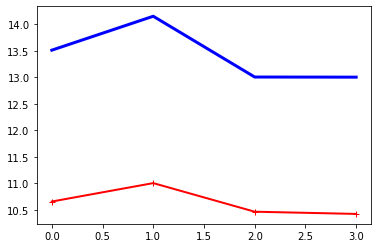

In [ ]:
# SVR model Learning Curve 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
def plot_learning_curves(model, x_train, y_train):
    X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range (1, 5):
        model.fit(X_train[:m*3], Y_train[:m*3])
        y_train_predict = model.predict(X_train[:m*3])
        y_test_predict = model.predict(X_test)
        train_errors.append(mean_squared_error(Y_train[:m*3], y_train_predict))
        val_errors.append(mean_squared_error(Y_test, y_test_predict))
    print(val_errors)
    plt.plot(np.sqrt(train_errors),"r-+", linewidth=2, label ="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label ="val")

lr =SVR(degree =2)
plot_learning_curves(lr, x_train_enc_scl_df, regression_y_train )

We have generated the learning curve for SVC with polynomial=2 [we have also done it for regression with polynomial features (data not shown)], to illustrate how the model actually fails. Normally , at the beginning of a learnig curve when the sample size is small we would expect that the training and the validation error rates are more similar. However by adding mode samples into the trainin and validation set we see how the model fails to fit the data. In our model, there is a huge gap  between the two curves that shows that the model performs better on the training set than the vaildation set. This is an indication that the model has high variance and it is overfitting.

**Random Forest Regressor**

RandomForestRegressor:
    One of the main challenge in this regression problem is the fact that the every attribure has different categories. RandomForestRegressor generates a random forest of decision trees and merges them together to obtain a more stable and accurate prediction through cross validation. RandomForest is an ensemble technique that is less prone to overfitting because it introduces extra randomness when growing the trees. Overfitting is of a concern in this case  because of the small dataset. In order to ensure that the model does not overfit the data, it is essential that the hyperparameters are tuned properly, especially "max_depth" and "n_estimators".In this case, the model managed to fit the data relatively well achieving a negative RMSE score of -10.20.


In [ ]:
#Grid Search RandomForestRegressor
model = RandomForestRegressor(random_state = 23)
parameters = {
    "n_estimators": [85,87,90],
    "criterion":  ['mse'],
    "max_depth": [26,28,30],
    "min_samples_split":[4,5,6],
    "max_features" : ['auto', 'sqrt', 'log2']
}
grid = GridSearchCV(estimator = model, cv=10, scoring = 'neg_root_mean_squared_error', param_grid=parameters)
grid.fit(x_train_enc_scl_df,regression_y_train)
print(grid.best_score_)
print(grid.best_params_)

-10.204059604111674
{'criterion': 'mse', 'max_depth': 26, 'max_features': 'sqrt', 'min_samples_split': 6, 'n_estimators': 85}


In [ ]:
#RandomForestRegressor model
rfr = RandomForestRegressor(n_estimators = 85, criterion='mse', max_features = 'sqrt', min_samples_split= 6, max_depth = 26, random_state = 23)
rfr.fit(x_train_enc_scl_df,regression_y_train)
y_predicted_rfr = rfr.predict(x_test_enc_scl_df)

#Cross-validation RandomForestRegressor
scores = cross_val_score(rfr, x_train_enc_scl_df, regression_y_train, cv=10,scoring = 'neg_root_mean_squared_error')
np.average(scores)

-10.310257106583302

**Gradient Boosting Regressor**

The final technique that was utilised was the GradientBoostingRegressor, which is another ensemble method that relies on adding sequnetially predictors to the ensemble that will correct its predecessor. For this particular problem the best conditions were for 100 trees (n_estimator) and low learning rate =0.3. This is favorable because we have restrained the contribution of each tree (learning rate), so we will need more trees to fit the training set and it is likely that the model will generalise better. Even though the performance of the model in the cross-validation was slightly worse than that of the RandomForestRegressor (-10.53 compared to 10.20 negative RMSE), it is highly probable that it will generalise better.

In [ ]:
#Grid Search GradientBoostingRegressor
model = GradientBoostingRegressor(random_state=23)
parameters = {
    "learning_rate": [0.3,0.35,0.4,0.45,0.5],
    "loss":  ["ls"],
    "n_estimators": [100,150,200],
    "criterion":["mse"],
    "min_impurity_decrease" : [0.025,0.03,0.02]
}
grid = GridSearchCV(estimator = model, cv=10, scoring = 'neg_root_mean_squared_error', param_grid=parameters)
grid.fit(x_train_enc_scl_df, regression_y_train)
print(grid.best_score_)
print(grid.best_params_)

-10.530220002855529
{'criterion': 'mse', 'learning_rate': 0.3, 'loss': 'ls', 'min_impurity_decrease': 0.025, 'n_estimators': 100}


In [ ]:
#GradientBoostingRegressor
gbr = GradientBoostingRegressor(n_estimators=100,learning_rate=0.3,loss="ls",criterion="mse", min_impurity_decrease=0.025,random_state=23)
gbr.fit(x_train_enc_scl_df,regression_y_train)
y_predicted_gbr = gbr.predict(x_test_enc_scl_df)

#Cross-validation GradientBosstingRegressor
scores = cross_val_score(gbr, x_train_enc_scl_df, regression_y_train, cv=10,scoring = 'neg_root_mean_squared_error')
np.average(scores)

-10.530220002855529

In [ ]:
#Preparing data for submission
pd.DataFrame(y_predicted_gbr).set_index(x_test_Id).rename(columns={0:'pop'}).to_csv('upload.csv')

## **Reflection on the Regression Problem**

For the regression problem we see that our best performers on the training data were  the RandomForest and the GradientBoosting. This is not surprising because RandomForest introduces extra randomness into the model that makes it more resistant to overfitting. Gradient Boost has also performed equally well because it is an Ensemble technique designed to correct the residual error and that makes it very suitable for regression problems.  On the contrary adding polynomial features to identify complex relationships between the features has not greatly helped the regression model. This is also confiremd when we plot the learning curves where we see that the model has very high variance which indicates overfit.

As for the results on the kaggle test data, as expected the LinearRegression model achieved the worst results due to its limitations that have been already discussed - 11.69 RMSE. What's more, even though the RandomForestRegressor achieved a slightly better score in comparison to the GradientBoostingRegressor on the training data, it was unable to outperform it on the test data. The GradientBoosting regressor managed to obtain a score of 7.44 RMSE, while the RandomForestRegressor scored 8.21. This incosistency in the results of the models on the training and test datasets can be explained by a level of overfitting within the model, which unfortunately is inevitable because of the small dataset and the fact that the dataset is very imbalanced. However, tuning the GradientBoost hyperparameters and reducing each tree's contirbution into the model helped to restrain overfitting which helped the model to generalise better and score high on the Kaggle dataset.

Finally, we have tried to apply Principal Component Analysis (PCA) in an attmept to reduce the dimensionality of the data (400 total features after encoding) and to facilitate the model fitting. However, we have noticed that in order to achieve more than 70% variance we needed to increase PCA=200. This is likely to do with the sparsity of the data. Still, when we fitted our model with  200PCAs our models underperformed. This is likely to do with the small dataset and the fact that we really need all the information we can get. This is a case where keeping higher number of dimensions actually benefitted the model.  Moving forward the model would greatly improve by a larger dataset. With a larger dataset we would be able to remove the outliers and retrain the model, which is likely to have resulted in better performance. A larger dataset also reduces the risk overfitting the data. Another approach would be to apply neural networks as a more flexible approach to adapt to the shape of the data, so it would dynamically pick the best type of regression.


---

# **Classification Analysis**

Below we introduce the data preprocessing along with the models with the best performance for the Classification problem. The target column has 83 different classes, which makes it a highly challenging multiclass classification problem. Similar to the Regression problem some classes have very few number of instances and this is likely to affect the model performance and probably introduce some bias since the model will "learn" to predict the ranks with the higher number of instances.

In [ ]:
# Load the data
clas_training = pd.read_csv('CS98XClassificationTrain.csv')
clas_test = pd.read_csv('CS98XClassificationTest.csv')
# Drop the identifier columns
clas_training.drop(['Id', 'title'], axis=1, inplace=True)
# Drop the 15 missing rows
clas_training.dropna(inplace=True)

In [ ]:
X_classification = clas_training.drop(['top genre'], axis=1)
X_classification = X_classification.reset_index(drop=True)

# Encode the target
le_classification = preprocessing.LabelEncoder()
le_classification.fit(clas_training['top genre'])
y_classification = le_classification.transform(clas_training['top genre'])

# Split the training data 80:20
from sklearn.model_selection import train_test_split
X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(X_classification, y_classification, test_size=0.20, random_state=42)

# Encode the training data
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc.fit(X_class_train['artist'].to_numpy().reshape(-1, 1))
artist_onehot = enc.transform(X_class_train['artist'].to_numpy().reshape(-1, 1))

# Make the 2d array a pandas series
ohe_df = pd.DataFrame(artist_onehot, columns=enc.get_feature_names())

X_class_train = X_class_train.drop(['artist'], axis=1)
X_class_train = X_class_train.reset_index(drop=True)
X_class_train = pd.concat([X_class_train, ohe_df], axis=1)

## **Training Classification Models**

Since the main task here was predicting the top genre of a song and because there weren't any specific requirements that would make us favour precision over recall or recall over precision, we chose to use the F1 score as the primary metric for assessing the performance of each model. As the F1 score is the harmonic mean of Precision and Recall, it is the perfect metric for this scenario.

We chose the 'macro' average parameter as it doesn't take into consideration the proportion of each class and thus each class is given the same importance no matter how frequently it occurs.

Overall we have not used any dimensionality reduction techniques since training the models was fairly quick and the data fit easily into memory. We were also careful not to lose any information, although it should be noted that we did try dropping some columns based on their correlation with the target variable but the scores did not change too much which is why we decided to keep the data as it is.

Similar to the Regression problem, we have used GridSearch for all the models to find the best values for our hyperparameters.

### Baseline Performance

We used a simple dummy classifier that would make predictions based on the target variable class distributions. It was used for establishing the baseline performance and then compare that to the real models used.

In [ ]:
from sklearn.dummy import DummyClassifier
scores = cross_validate(DummyClassifier(strategy="stratified"), X_class_train, y_class_train, cv=5,scoring=('f1_macro'), return_train_score=True)
print("Training Score: " + str(np.average(scores['train_score'])))
print("Test Score: " + str(np.average(scores['test_score'])))

Training Score: 0.014276620631539541
Test Score: 0.02592972952940456


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


The the highest score the stratified strategy managed to achieve was around 0.022 for the test set, which for the most part was expected, as we have 86 classes to predict, so even if we are to randomly make our predictions the average accuracy would be around 0.012

### One vs. Rest SVC

In [ ]:
sc = StandardScaler()
sc.fit(X_class_train)
X_class_train_scaled = sc.transform(X_class_train)

In [ ]:
clf = SVC(kernel="sigmoid", degree=1, coef0=1, C=5, gamma = "scale")
ovr_clf = OneVsRestClassifier(clf)
scores = cross_validate(ovr_clf, X_class_train_scaled, y_class_train, cv=5,scoring=('f1_macro'), return_train_score=True)
print("Training Score: " + str(np.average(scores['train_score'])))
print("Test Score: " + str(np.average(scores['test_score'])))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Training Score: 1.0
Test Score: 0.3025164978802354


Because this is a multiclass problem we have used a OneVsRestClassifier, that allows us to train each class against the rest. The One vs. Rest classifier is especially useful here, since for some of the classes there is very little training data, so by using the One vs. Rest method, we get a larger sample of negative instances which should help the model. We also have chosen to use Support Vector Classification (SVC) with soft margin classification because the classes are unlikely to be linearly separated. We have also opted for polynomial=1. Increase of polynimial did not improve the score possibly because we have already used the Kernel that maps the data into higher dimensional spaces

As we can see from the score of the model 0.3025, it is already much higher than the baseline performance of our DummyClassifier. 

#### Grid search for better values SVC

In [ ]:
from sklearn.model_selection import GridSearchCV
clf = SVC()
ovr_clf = OneVsRestClassifier(clf)
parameters = {
    "estimator__C": [5, 10, 7, 100, 500, 1000],
    "estimator__kernel": ["poly","rbf", "sigmoid"],
    "estimator__degree":[1, 2, 3, 5, 7],
}
#Uncomment to run. It takes very long time!
#grid_search = GridSearchCV(estimator=ovr_clf, param_grid=parameters, return_train_score=True, scoring='f1_macro')
#grid_search = grid_search.fit(X_class_train_scaled, y_class_train)
#grid_search.best_params_

### Multiclass Logistic Regression

Logistic regression is a fairly standard choice when it comes to classification problems. One of the reasons we chose it for the problem here is because of its ability to return probability estimates which we wanted to later use in a soft voting ensemble model. Additionally Logstic Regression deals fairly well with mixed data sets, that have both categorical and numerical data.

In [ ]:
from sklearn.linear_model import LogisticRegression
scores = cross_validate(LogisticRegression(C=10,solver='newton-cg', penalty='l2'), X_class_train_scaled, y_class_train, cv=5,scoring=('f1_macro'), return_train_score=True)
print("Training Score: " + str(np.average(scores['train_score'])))
print("Test Score: " + str(np.average(scores['test_score'])))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Training Score: 1.0
Test Score: 0.3021126433157728


As we can see the Logistic Regression performs fairly similarly to the OneVsRest SVC. Logistic Regression is a very powerful model even for multi-class problems and it is a very reliable classifier.

#### Grid search for hyperparameter tuning

In [ ]:
from sklearn.linear_model import LogisticRegression
parameters = {
    "C": [10, 100, 500, 1000],
    "penalty": ['l1', 'l2', 'elasticnet'],
    "class_weight":['balanced', None],
    "solver":['newton-cg', 'liblinear', 'sag', 'saga'],
}
# Prints warnings because some parameters are not compatible with others
# Uncomment to run, it takes a while
# grid_search = GridSearchCV(estimator=LogisticRegression(n_jobs=-1, max_iter=2000), param_grid=parameters, return_train_score=True, scoring='f1_macro')
# grid_search = grid_search.fit(X_class_train_scaled, y_class_train)
# grid_search.best_params_

We opted for Logistic Regression and "newton-cg" that handles multiclass problems. In this case increasing the C parameter did not reduce the overall score, so  we kept it high to avoid margin violations (something that will probably is of concern with so many classes), although this could come at the expense of regularization

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
scores = cross_validate(ExtraTreesClassifier(max_depth=30, n_estimators=500, criterion='gini', class_weight='balanced'), X_class_train_scaled, y_class_train, cv=5,scoring=('f1_macro'), return_train_score=True)
print("Training Score: " + str(np.average(scores['train_score'])))
print("Test Score: " + str(np.average(scores['test_score'])))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Training Score: 1.0
Test Score: 0.2711964204435555


Unexpectedly, the Random Forest model did not perform particualrly well, with the Extra Trees model performing only slightly better than it. We supsect this has to do with the sparcity of the data and the fact that we have a very large number of features with very few training samples. In this case the very few instances per node is likely what results in poor performance.

#### Grid search for hyperparameter tuning

In [ ]:
parameters = {
    "max_depth": [3, 5, 10, 15, 20, 25, 30, 60, None],
    "n_estimators": [10, 100, 500, 1000],
    "class_weight":['balanced', None],
    "criterion": ['gini', 'entropy']
}
#grid_search = GridSearchCV(estimator=ExtraTreesClassifier(), param_grid=parameters, return_train_score=True, scoring='f1_macro')
#grid_search = grid_search.fit(X_class_train_scaled, y_class_train)
#grid_search.best_params_

### Gradient Boost

In [ ]:
gb_clf = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, max_depth=5)
scores = cross_validate(gb_clf, X_class_train_scaled, y_class_train, cv=5,scoring=('f1_macro'), return_train_score=True)
print("Training Score: " + str(np.average(scores['train_score'])))
print("Test Score: " + str(np.average(scores['test_score'])))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Training Score: 1.0
Test Score: 0.2830469372211177


We have used GradientBoostingClassifier asn ensemble method that aims to correct the residual error by adding sequnetially predictors to the ensemble.  GradientBoostingClassifier was a suitable choice for the multiclassification problem because our model is likely to have more bias (low number of instances) than variance so it will be prone to overfitting.  Because correcting the residual error refers mostly to regression problems, for our problem  GradientBoostingClassifier performed better  with higher learning rate compared to the regression (1.0 vs 0.3) and smaller number of trees that are added to correct the residual error. By increasing the learnign rate and decreasing the number of trees we have better chance for classification but our model is more likely to be prone to overfitting.



#### Grid search for hyperparameter tuning

In [ ]:
parameters = {
    "max_depth": [3, 5, 10, 15, 20, 25, 30, 60, None],
    "n_estimators": [10, 100, 500, 1000],
    "learning_rate":[0.5, 0.9, 1.0, 1.2],
}
# grid_search = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=parameters, return_train_score=True, scoring='f1_macro')
# grid_search = grid_search.fit(X_class_train_scaled, y_class_train) # Beware: Ran for like 3hrs dont run it
# grid_search.best_params_
# Results:
# {'learning_rate': 1.0, 'max_depth': 5, 'n_estimators': 10}

### Soft Voting Classifier

In [ ]:
from sklearn.ensemble import VotingClassifier
ovr_svc_clf = OneVsRestClassifier(SVC(kernel="sigmoid", degree=1, coef0=1, C=5, gamma = "scale",probability=True))
gb_clf = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, max_depth=5)
extra_trees = ExtraTreesClassifier(max_depth=30, n_estimators=500, criterion='gini', class_weight='balanced')
logistic_reg = LogisticRegression(C=10,solver='newton-cg', penalty='l2')

vc_clf = VotingClassifier(estimators=[("log_reg", logistic_reg), ("ovr_svc_clf", ovr_svc_clf), ("gb_clf", gb_clf), ("extra_trees", extra_trees)], 
                          n_jobs=-1, voting='soft')

scores = cross_validate(vc_clf, X_class_train_scaled, y_class_train, cv=5,scoring=('f1_macro'), return_train_score=True)
print("Training Score: " + str(np.average(scores['train_score'])))
print("Test Score: " + str(np.average(scores['test_score'])))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Training Score: 1.0
Test Score: 0.29759076832802184


For the soft voting classifier we decided to use all of the best performing models: the One vs Rest SVC, the Logistic Regression, GradientBoost and ExtraTrees models. So while the last two are underperforming compared to the first two, we are hoping that because we have a voting classifier that votes based on the confidence of each model and because we have such a big diversity of algorithms used, the final ensemble voter will overall generalize better. 

We can see that there is a slight decrease in the performance, around 0.005. We deem that to be a negligible difference, as said previously we hope that it would still generalize better. This is why we also chose it as the final model for the classification task.

## **Test Set Evaluation**

In [ ]:
clf = SVC(kernel="sigmoid", degree=1, coef0=1, C=5, gamma = "scale",probability=True)
ovr_clf = OneVsRestClassifier(clf)
gb_clf = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, max_depth=5)
extra_trees = ExtraTreesClassifier(max_depth=30, n_estimators=500, criterion='gini', class_weight='balanced')
vc_clf = VotingClassifier(estimators=[("log_reg", LogisticRegression(C=10,solver='newton-cg', penalty='l2')), ("ovr_svm", ovr_clf), ("gb_clf", gb_clf), ("extra_trees", extra_trees)], n_jobs=-1, voting='soft')
vc_clf = vc_clf.fit(X_class_train_scaled, y_class_train)

In [ ]:
# Encode the test using the fit one hot encoder
artist_onehot = enc.transform(X_class_test['artist'].to_numpy().reshape(-1, 1))
# Make the 2d array a pandas series
ohe_df = pd.DataFrame(artist_onehot, columns=enc.get_feature_names())

X_class_test_encoded = X_class_test.drop(['artist'], axis=1)
X_class_test_encoded = X_class_test_encoded.reset_index(drop=True)
X_class_test_encoded = pd.concat([X_class_test_encoded, ohe_df], axis=1)

In [ ]:
sc_test = StandardScaler()
sc_test.fit(X_class_test_encoded)
X_class_test_scaled = sc_test.transform(X_class_test_encoded)
predictions = vc_clf.predict(X_class_test_scaled)

from sklearn.metrics import f1_score
print(f1_score(y_class_test,predictions, average='macro'))

0.312197971194511



So here we see a slight increase in the prediction power of the ensemble voter, which might very well be due to the fact that we are training on the whole of the training set as opposed to during the cross-validation phase where the training set is much smaller. Additionally there are some classes that appear only once in the target variable which my be further driving down the score during the cross validation, so the model here does not encounter such difficulties.





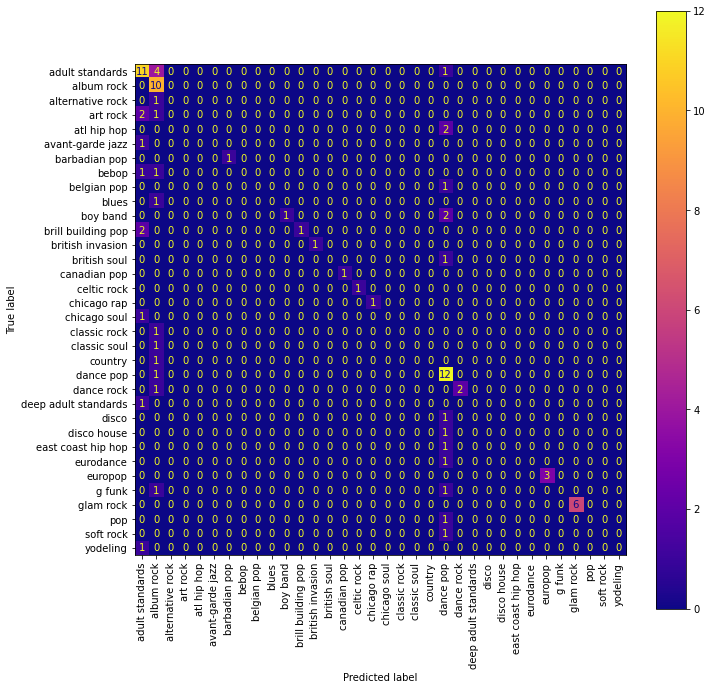

In [ ]:
total_predicted = np.concatenate((predictions, y_class_test))
unique_predicted = np.unique(total_predicted)
fig, ax = plt.subplots(figsize=(11, 11))
plot_confusion_matrix(vc_clf, X_class_test_scaled, y_class_test, labels=unique_predicted, ax=ax, display_labels=le_classification.inverse_transform(unique_predicted), xticks_rotation='vertical', cmap='plasma')
plt.show()

## **Reflection on the Classification Problem**

As we can see from the confusion matrix the model built has a tendency to confuse most other genres for 'adult standards', 'album rock' and 'dance pop'. Coincidentally these are also the most commonly occuring classes in the dataset.
On the other hand genres like 'yodeling', 'disco house', 'art rock' and many others are much less commonly ocurring, so the model is having trouble distinguishing them correctly resulting in poorer performence when trying to predict these less commonly occuring classes. The model has learnt well the most occuring classes and assigns other instances to those classes by mistake. This is something to be expected considering the  small training set. This is also due to the outliers , which will have greater impact on the model.

The solution in this case is to either add more data into the model or perfrom oversampling. In this way we could sample repeatedly the classes with the low number of instances in order to give a chance to the model to learn these classes equally well.

For some of the models, such as the logistic regression, there is the imbedded option of having class_weight which adds class weights for unbalanced datasets, which did result in a slightly better model performance for us. 

Additionally possibly performing some feature engineering, where we could combine some of the independent variables could help boost the performance of the model.

## **Submission Code** 

In [ ]:
# Prepare the full data
X_class_train = clas_training.drop('top genre', axis=1)
X_class_train = X_class_train.reset_index(drop=True)
# Encode the target
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(clas_training['top genre'])
y_class_train = le.transform(clas_training['top genre'])
# Encode the training data
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc.fit(X_class_train['artist'].to_numpy().reshape(-1, 1))
artist_onehot = enc.transform(X_class_train['artist'].to_numpy().reshape(-1, 1))
# Make the 2d array a pandas series
ohe_df = pd.DataFrame(artist_onehot, columns=enc.get_feature_names())

X_class_train = X_class_train.drop(['artist'], axis=1)
X_class_train = X_class_train.reset_index(drop=True)
X_class_train = pd.concat([X_class_train, ohe_df], axis=1)

In [ ]:
sc = StandardScaler()
sc.fit(X_class_train)
X_class_train_scaled = sc.transform(X_class_train)

clf = SVC(kernel="sigmoid", degree=1, coef0=1, C=5, gamma = "scale",probability=True)
ovr_clf = OneVsRestClassifier(clf)
gb_clf = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, max_depth=5)
extra_trees = ExtraTreesClassifier(max_depth=30, n_estimators=500, criterion='gini', class_weight='balanced')
vc_clf = VotingClassifier(estimators=[("log_reg", LogisticRegression(C=10,solver='newton-cg', penalty='l2')), ("ovr_svm", ovr_clf), ("gb_clf", gb_clf), ("extra_trees", extra_trees)], n_jobs=-1, voting='soft')
# Train on the whole dataset
vc_clf = vc_clf.fit(X_class_train_scaled, y_class_train)

In [ ]:
# Process the test data
# 1. Encode the test data
artist_onehot = enc.transform(clas_test['artist'].to_numpy().reshape(-1, 1))
# Make the 2d array a pandas series
ohe_df = pd.DataFrame(artist_onehot, columns=enc.get_feature_names())
X_class_test = clas_test.drop(['artist', 'title', 'Id'], axis=1)
X_class_test = X_class_test.reset_index(drop=True)
X_class_test = pd.concat([X_class_test, ohe_df], axis=1)

In [ ]:
# Make predictions
test_sc = StandardScaler()
test_sc.fit(X_class_test)
X_final_test_scaled = test_sc.transform(X_class_test)
predictions = vc_clf.predict(X_final_test_scaled)

In [ ]:
res = pd.DataFrame(le.inverse_transform(predictions), columns=['top genre'])
res = pd.concat([clas_test['Id'], res], axis=1)
res.to_csv('group_7_classification_submission.csv', index=False)

With regards to the performance on the Kaggle leaderboard, the model performance jumped from 31.2% to 57.1%. This might be due to a variety of reasons.

First our final model is trained on the whole of the dataset and as seen previously adding more data deffinetely helps it perform better. 

Additionally the test set itself may contain a lot of instances of the most popular classes which may further drive up the score as our soft voting ensemble model is good at recognizing those.

Finally, just as we speculated the fact that we are using a soft voter may very well help with generalizing better. It is fairly hard to see that here however, because even when splitting the data there are a lot of instance that occur only once or twice. So depending on the split of the data the model may not see some classes that are present in the test set but not in the traning set, so stratified splitting is difficult to execute in this circumstance.

Comparing the model's score to the other models on the leaderboard we can see that our model is one of the higher scoring ones. We suspect that this may be due to the fact that we are training our final model on the full dataset and that we have four well tuned models combined in a single soft voting ensemble model, which should make a big difference in the performance.